In [5]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DATAFILE = "../data/raw/beer_reviews.csv"
OUTDATADIR = "../data/beer/"
NUMFOLDS = 5

In [6]:
def createBeerLookup(df, save=True):
    # Create a beer lookup table of ID to name
    beerData = df[['beer_beerid', 'beer_name', 'beer_style', 'review_overall']].copy()
    beerData['beer_style_id'] = beerData['beer_style'].astype('category').cat.codes
    beerNames = beerData.drop(columns=['review_overall']).drop_duplicates().set_index('beer_beerid')
    beerAvgRating= beerData.groupby('beer_beerid')[['beer_beerid', 'review_overall']].mean().set_index('beer_beerid')
    beerLookup = beerNames.join(beerAvgRating, how='inner')
    if save:
        beerLookup.to_csv(BEERLOOKUPDIR + "beerLookup.csv")
    return beerLookup

In [7]:
def createCollaborativeDataset(df, save=True):
    # (user, item, rating) format
    collaborativeDataset = df.loc[:, ['review_profilename', 'beer_beerid', 'review_overall']].copy()
    collaborativeDataset["review_profilename"] = collaborativeDataset["review_profilename"].astype('category').cat.codes
    collaborativeDataset = shuffle(collaborativeDataset)

    # Split datasets into folds
    splits = np.array_split(collaborativeDataset, NUMFOLDS)
    if save:
        for k, dataset in enumerate(splits):
            dataset.to_csv(OUTDATADIR + "fold" + str(k), index=False, header=False)
    return splits

In [9]:
df = pd.read_csv(DATAFILE)
df.head(2)
df.dropna(0, inplace=True)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213


In [17]:
beer_ratings = df[['beer_name', 'review_overall']].groupby('beer_name').agg(['mean', 'count']).review_overall
beer_ratings = beer_ratings[beer_ratings['count'] > 5]

In [19]:
profile_reviews = df[['review_profilename', 'beer_name', 'review_overall', 'beer_style']]
profile_reviews = profile_reviews.set_index('beer_name')

In [21]:
joined = profile_reviews.join(beer_ratings)
joined = joined.dropna()

#### RMSE for predicting the average rating

In [49]:
overallMean = joined.review_overall.mean()
((joined.review_overall - overallMean) ** 2).mean() ** .5

0.7140937397835865

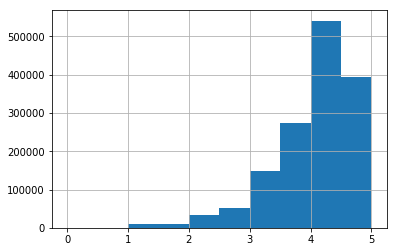

In [26]:
joined.review_overall.hist()